## Solution Approach

A mathematical optimization model has five components, namely:

* Sets and indices.
* Parameters.
* Decision variables.
* Objective function(s).
* Constraints.

## Model Formulation

### Sets and Indices

$G(N,E)$: Graph that represents the airport network, where $N$ is the set of vertices and $E$ is the set of edges. The sirports are vertices in the set of nodes $N$ of the graph. The set of flight paths are the edges of the graph.(we assume there is a flight path between each pair of airports) 

### Parameters
$d_{i,j} \in \mathbb{R}^+ $:haversine distance from vertex $i \in N$ to vertex $j \in N$.



### Decision Variables
$x_{ij} = \begin{cases} 
1 & \text{if arc from node } i \text{ to node } j \text{ is traversed, } i \neq j; \\
0 & \text{otherwise.}
\end{cases}$


## Miller-Tucker-Zemlin TSP Formulation
# 
### Objective Function
Minimize the total distance traveled:
# 
$$
\min \sum_{i \in N} \sum_{j \in N} d_{ij} x_{ij}
$$
# 
### Constraints
1. Each node must be departed from exactly once:
$$
\sum_{j \in N, j \neq i} x_{ij} = 1 \quad \forall i \in N
$$
2. Each node must be arrived at exactly once:
$$
\sum_{i \in N, i \neq j} x_{ij} = 1 \quad \forall j \in N
$$
3. Subtour elimination constraints:
$$
u_i + 1 \leq u_j + (n-1)(1-x_{ij}), \quad \forall i \in N, j \in N, i \neq j \neq 1
$$
4. No self-loops:
$$
x_{ii} = 0 \quad \forall i \in N
$$
5. Binary constraints on decision variables:
$$
x_{ij} \in \{0, 1\} \quad \forall i \in N, j \in N, i \neq j
$$
6. Order constraints:
$$
u_1 = 1
$$
$$
2 \leq u_i \leq n \quad \forall i \in N, i \neq 1
$$
7. return to airport dummy constraint
$$x_{1,0}=1
$$



In [5]:
from pprint import pprint
import pandas as pd
import networkx as nx
from haversine import haversine, Unit

# Load the data
data = pd.read_csv('airports.csv')
# Add one to the first column value
data['Unnamed: 0'] = data['Unnamed: 0'] + 1

# Create a graph
G = nx.Graph()

# Add nodes
for index, row in data.iterrows():
    G.add_node(row['Unnamed: 0'], country=row['country'], airport_name=row['airport_name'], airport_code=row['airport_code'], latitude_deg=row['latitude_deg'], longitude_deg=row['longitude_deg'])

# Add edges with haversine distance as weight
for i, row1 in data.iterrows():
    for j, row2 in data.iterrows():
        if i != j:
            coord1 = (row1['latitude_deg'], row1['longitude_deg'])
            coord2 = (row2['latitude_deg'], row2['longitude_deg'])
            distance = haversine(coord1, coord2,unit=Unit.KILOMETERS)
            G.add_edge(row1['Unnamed: 0'], row2['Unnamed: 0'], weight=distance)

print(G)

Graph with 45 nodes and 990 edges


In [6]:
from gurobipy import *
import gurobipy as gp
import numpy as np
import random

import matplotlib.pyplot as plt
import networkx as nx
# Create a new model
mtz = gp.Model("TSP_MTZ")
# mtz.Params.MIPGap = 0.13  # Set the target accuracy to 5% of the optimal
# Step 4: Solve the Model with Parameters
mtz.setParam('MIPGap', 0.08)  # Allow a 5% gap from the optimal solution

# Create variables
# also satisfy constraint 4 and 5
vars = mtz.addVars([(i, j) for i in G.nodes for j in G.nodes if i != j],
                     vtype=GRB.BINARY, name="e")

# Subtour elimination decision variables
u = mtz.addVars(G.nodes, vtype=GRB.CONTINUOUS, name="u", lb=1, ub=len(G.nodes))

# Objective: minimize the total distance traveled
mtz.setObjective(gp.quicksum(vars[i, j] * G[i][j]['weight'] 
                               for i in G.nodes for j in G.nodes if i != j), GRB.MINIMIZE)

# Constraints
# 1.and 2.
# Each node is entered and left exactly once
for i in G.nodes:
    mtz.addConstr(gp.quicksum(vars[i, j] for j in G.nodes if i != j) == 1)
    mtz.addConstr(gp.quicksum(vars[j, i] for j in G.nodes if i != j) == 1)


# 3. Subtour elimination constraints (MTZ)
n = len(G.nodes)
for i in list(G.nodes)[1:]:  # Skip the first node
    for j in list(G.nodes)[1:]: 
        if i != j:
            mtz.addConstr(u[i] - u[j] + (n - 1) * vars[i, j] <= n - 2)
mtz.addConstr(u[1] == 1)  # Fix the position of the first node

# 6.order constraint
for i in list(G.nodes)[1:]:
    mtz.addConstr(u[i] >= 2)
    mtz.addConstr(u[i] <= len(G.nodes))

# 7.return to airport dummy constraint
mtz.addConstr(vars[2, 1] == 1)


# Solve the model
mtz.optimize()

# Output the solution
if mtz.status == GRB.OPTIMAL:
    edges = [(i, j) for i in G.nodes for j in G.nodes if i != j and vars[i, j].X > 0.5]
    print("Optimal tour:", edges)
else:
    print("No optimal solution found")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-08
Set parameter MIPGap to value 0.08
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-13500H, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 2072 rows, 2025 columns and 9726 nonzeros
Model fingerprint: 0xba5d9583
Variable types: 45 continuous, 1980 integer (1980 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [1e+02, 2e+04]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 135 rows and 89 columns
Presolve time: 0.02s
Presolved: 1937 rows, 1936 columns, 9290 nonzeros
Variable types: 43 continuous, 1893 integer (1893 binary)
Found heuristic solution: objective 242962.85862
Found heuristic solution: objective 241596.76253

Root relaxation: objective 4.335597e+04, 165 iter

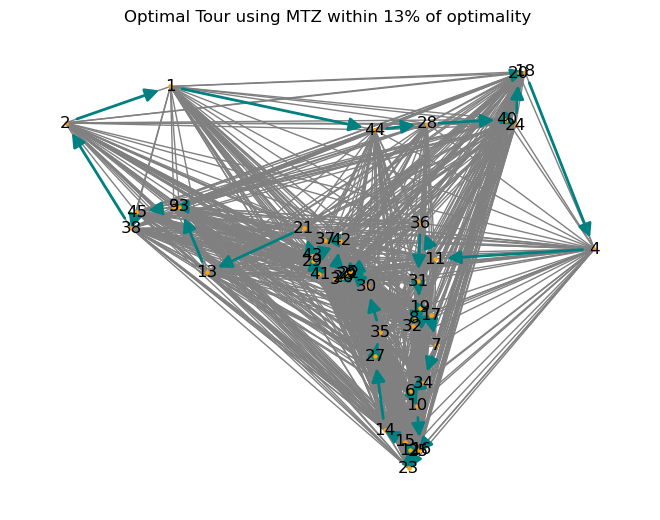

In [7]:
# Define the optimal tour provided by gurobi
optimal_tour = edges

# Draw the network with the optimal path highlighted
G_optimal = nx.DiGraph()
G_optimal.add_edges_from(optimal_tour)
# Define the positions of the nodes based on latitude and longitude
pos = {node: (G.nodes[node]['longitude_deg'], G.nodes[node]['latitude_deg']) for node in G.nodes}

# Draw the full graph with all nodes
nx.draw(G, pos, with_labels=True, node_color='orange', node_size=5, edge_color='gray', arrows=True)

# Overlay the optimal tour with a different edge color
nx.draw_networkx_edges(G_optimal, pos, edge_color='teal', width=2, arrows=True, arrowstyle='-|>', arrowsize=20)

plt.title('Optimal Tour using MTZ within 13% of optimality ')
plt.show()

# Lazy Constraints TSP Formulation

### Constraints

 **Subtour elimination constraints (Lazy Constraints)**:
   - The **Lazy Constraints** method does not add all subtour elimination constraints at the initialization of the model. Instead, these constraints are added dynamically during the solution process.
   - Whenever the solver finds an integer solution, it checks for the existence of any subtours (disconnected cycles). If a subtour is found, a constraint is added to eliminate that subtour.
   - The specific form of the constraint is: for each subtour `S` in the current solution, add the following constraint to ensure the number of selected edges in `S` is less than the number of nodes in `S`, preventing it from forming a cycle:

 $$
   \sum_{i \in \text{S}}  \sum_{j\in \text{S}; j\neq i} x_{ij}\leq |\text{S}| - 1
   $$

   where `S` represents a subtour (disconnected cycle) in the current solution.

### Introduction to Lazy Constraints Method

**Lazy Constraints** is a technique for dynamically adding constraints. Unlike traditional methods, Lazy Constraints do not add all subtour elimination constraints at the beginning of the model. Instead, they allow the solver to find an integer solution and then check whether that solution includes subtours (disconnected cycles). If a subtour is detected, a constraint is added to prevent that subtour from being part of the final solution. 

The advantage of this method is that it significantly reduces the number of initial constraints, simplifying the model and improving the solution efficiency. This approach is particularly suitable for combinatorial optimization problems with numerous potential subtours, such as the Traveling Salesman Problem (TSP).

In each iteration where the solver finds an integer solution, the callback function checks for subtours within that solution. If subtours are present, a constraint is added to limit the number of edges in the subtour, forcing the solver to avoid that subtour in subsequent solutions, progressively leading to an optimal solution with a single connected tour that visits all nodes.


In [9]:
# Create a new model
mlc = gp.Model("TSP_Lazy")
#mlc.Params.MIPGap = 0.05  # Set target accuracy to 5%
mlc.Params.lazyConstraints = 1  # Enable Lazy Constraints

# Create binary decision variables
vars = mlc.addVars([(i, j) for i in G.nodes for j in G.nodes if i != j], vtype=GRB.BINARY, name="e")

# Objective: minimize the total distance traveled
mlc.setObjective(gp.quicksum(vars[i, j] * G[i][j]['weight'] for i in G.nodes for j in G.nodes if i != j), GRB.MINIMIZE)

# Constraints: Each node is entered and left exactly once
for i in G.nodes:
    mlc.addConstr(gp.quicksum(vars[i, j] for j in G.nodes if i != j) == 1)
    mlc.addConstr(gp.quicksum(vars[j, i] for j in G.nodes if i != j) == 1)

# Return to airport dummy constraint
mlc.addConstr(vars[2, 1] == 1)  # Ensure last step is from LAX (2) to JFK (1)

# Define the Lazy Constraint callback function
def subtour_elimination_callback(model, where):
    if where == GRB.Callback.MIPSOL:
        # Get the current solution edges
        selected_edges = [(i, j) for i, j in vars.keys() if model.cbGetSolution(vars[i, j]) > 0.5]
        
        # Find all subtours in the solution
        tours = find_subtours(selected_edges)
        #print(tours)
        
        # Add subtour elimination constraints for any subtour found
        for tour in tours:
            if len(tour) < len(G.nodes):
                # Add constraint to eliminate subtour
                model.cbLazy(gp.quicksum(vars[i, j] for i in tour for j in tour if i != j) <= len(tour) - 1)

# Helper function to find subtours in the current solution
def find_subtours(edges):
    # Create a subgraph of the selected edges
    subgraph = nx.Graph()
    subgraph.add_edges_from(edges)
    
    # Find all connected components (subtours) in the graph
    return [list(component) for component in nx.connected_components(subgraph)]

# Optimize the model with Lazy Constraint callback
mlc.optimize(subtour_elimination_callback)

# Output the solution
if mlc.status == GRB.OPTIMAL or mlc.status == GRB.TIME_LIMIT:
    edges = [(i, j) for i, j in vars.keys() if vars[i, j].X > 0.5]
    print("Optimal tour (or best feasible solution found within time limit):", edges)
    print("Objective value:", mlc.objVal)
else:
    print("No feasible solution found")

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-13500H, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 91 rows, 1980 columns and 3961 nonzeros
Model fingerprint: 0x136c5d24
Variable types: 0 continuous, 1980 integer (1980 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 3 rows and 87 columns
Presolve time: 0.00s
Presolved: 88 rows, 1893 columns, 3786 nonzeros
Variable types: 0 continuous, 1893 integer (1893 binary)

Root relaxation: objective 4.740529e+04, 122 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time



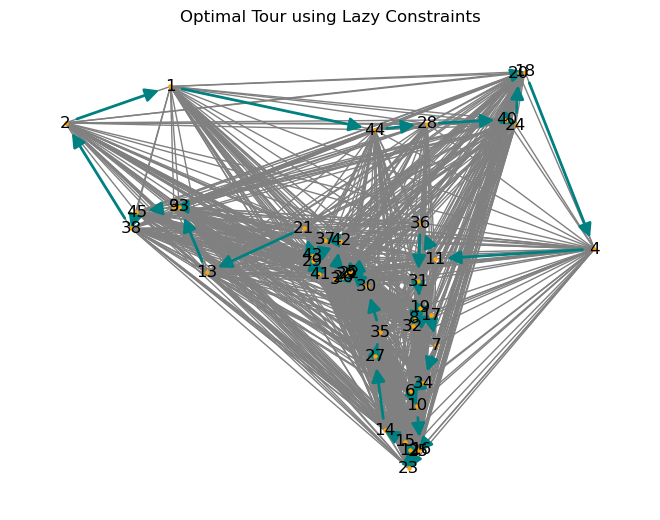

In [10]:
# Define the optimal tour provided by gurobi
optimal_tour = edges

# Draw the network with the optimal path highlighted
G_optimal = nx.DiGraph()
G_optimal.add_edges_from(optimal_tour)
# Define the positions of the nodes based on latitude and longitude
pos = {node: (G.nodes[node]['longitude_deg'], G.nodes[node]['latitude_deg']) for node in G.nodes}

# Draw the full graph with all nodes
nx.draw(G, pos, with_labels=True, node_color='orange', node_size=5, edge_color='gray', arrows=True)

# Overlay the optimal tour with a different edge color
nx.draw_networkx_edges(G_optimal, pos, edge_color='teal', width=2, arrows=True, arrowstyle='-|>', arrowsize=20)

plt.title('Optimal Tour using Lazy Constraints')
plt.show()